In [1]:
from typing import List
import pandas as pd
import json
from pathlib import Path
from utils import *

### preamble

In [2]:
setting_files = [p for p in Path("data/results/").glob("*.json")]

In [3]:
def get_annotations_from_csv(list_of_setting_jsons: List[str], annotation_df: pd.DataFrame):
    """
    --> note that for re-creating results without access to text of passages, we changed the code.
    """
    annotated_per_setting = {}
    rows = [row[1] for row in annotation_df.iterrows()]
    print(len(rows))
    for file in list_of_setting_jsons:
        setting_name = file.stem
        setting_dict = {}
        
        relevant_rows = []
        relevant_ranks = []
        for row_idx, row in enumerate(rows):
            settings_in_row = row['settings'][2:-2].split("', '")
            ranks_in_row = [int(x) for x in row['ranks'][1:-1].split(", ")]
            if len(ranks_in_row) != len(settings_in_row):
                print(row_idx)
            if setting_name in settings_in_row:
                relevant_rows.append(row)
                settings_idx = settings_in_row.index(setting_name)
                relevant_ranks.append(ranks_in_row[settings_idx])

        # and grab the annotations from the DF
        for row, rank in zip(relevant_rows, relevant_ranks):
            query = row['query']
            document_title = row['document_title']
            page_nr = row['page_nr']
#             text = row['text']
            # trying to create a unique identifier for each query + result pair, without looking at the text
            qr_combo = query.strip() + document_title.strip() + str(page_nr) + str(rank)
            annotation = row['relevance']
            
            if qr_combo not in setting_dict:
                setting_dict[qr_combo] = {'query': query, 
#                                           'text': text, 
                                          'rank': rank, 
                                          'page_nr': page_nr,  
                                          'document_title': document_title,
                                          'relevance': annotation}
            else:
                print("Duplicate results should not happen")
            
        annotated_per_setting[setting_name] = setting_dict
    return annotated_per_setting

In [4]:
def metrics(annotations, query_type=None):
    """ 
    Parses a dictionary like {qr_combo: {query: q, text: t, relevance: r}} --> note that for re-creating results
    without access to text of passages, we changed the code.
    """
    

    total_passages = 0
    true_positives = 0
    false_positives = 0
    total_queries = 0
    sum_of_F1s = 0
    sum_of_APs = 0
    sum_of_MRR = 0

    queries = []
    for qr_combo, q_t_a_r in annotations.items():
        
        query = q_t_a_r['query']
#         text = q_t_a_r['text']
        page_nr = q_t_a_r['page_nr']
        annotation = q_t_a_r['relevance']
        relevant = True if annotation in ['Yes', 'yes', 'y', 'Y'] else False
        irrelevant = True if annotation in ['No', 'no', 'n', 'N', 'h'] else False
        passage_rank = q_t_a_r['rank']
        
        if query not in queries:
            if queries:
                # convert previous bool_list into a score
                sum_of_F1s += F1_at_k(query_bool_list, len(query_bool_list))
                sum_of_MRR += MRR_query(query_bool_list)
                sum_of_APs += AP_query(query_bool_list)
            old_len = len(queries)
            queries.append(query)
            query_bool_list = []


        
        if relevant:
            total_passages += 1
            # True positives
            true_positives += 1
            query_bool_list.append(True)
        elif irrelevant:
            total_passages += 1
            # False positives
            false_positives += 1
            query_bool_list.append(False)
            
    sum_of_F1s += F1_at_k(query_bool_list, len(query_bool_list))
    sum_of_MRR += MRR_query(query_bool_list)
    sum_of_APs += AP_query(query_bool_list)
    
    total_queries = len(queries)
    avgF1 = sum_of_F1s / total_queries
    MAP = sum_of_APs / total_queries
    MRR = sum_of_MRR / total_queries

#     print(f"Total queries: {total_queries}, Total passages: {total_passages}, Total relevant: {true_positives}")

#     print("avg F1: {:.2f}".format(avgF1 * 100))
#     print("MRR: {:.2f} ".format(MRR * 100))
#     print("MAP: {:.2f} ".format(MAP * 100))
    

    avgf1_ = "{:.2f}".format(avgF1 * 100)
    mrr_ = "{:.2f}".format(MRR * 100)
    map_ = "{:.2f}".format(MAP * 100)
    
    results = {
        "avg F1": avgf1_,
        "MRR": mrr_,
        "MAP": map_,
        "true_positives": true_positives
    }
    return results


In [5]:
def results_table(annotated_dicts):
    order = ['sparse', 'sparse_QE', 'sparse_DE', 'sparse_DE_QE', 
         'dense', 'dense_QE', 'dense_DE', 'dense_QE_DE', 
         'hybrid', 'hybrid_QE',  'hybrid_DE', 'hybrid_QE_DE']
    total_results = {"avg F1": [], "MRR": [], "MAP": [], "true_positives": []}
    for k in order:
    #     print(f"\n{k}")
        results = metrics(annotated_dicts[k])
        for k, v in results.items():
            total_results[k].append(v)
    return pd.DataFrame.from_dict(total_results, orient='index', columns=order)

### combined

In [6]:
non_text_results = pd.read_csv(Path("data/annotated_results_top3.csv"))
annotated_dicts = get_annotations_from_csv(setting_files, non_text_results)
results_table(annotated_dicts) 

346


,sparse,sparse_QE,sparse_DE,sparse_DE_QE,dense,dense_QE,dense_DE,dense_QE_DE,hybrid,hybrid_QE,hybrid_DE,hybrid_QE_DE
avg F1,47.62,48.10,59.76,59.05,44.05,48.10,59.29,56.90,44.05,48.10,59.29,56.90
MRR,56.35,50.00,66.27,65.48,49.21,51.98,61.51,63.89,49.21,51.98,61.51,63.89
MAP,54.96,50.00,65.28,64.48,47.82,52.78,61.71,63.10,47.82,52.78,61.71,63.10
true_positives,50,50,65,63,47,50,65,60,47,50,65,60


### figure

In [7]:
import random, os
import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
import math
from collections import Counter

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

In [8]:
queries = open("data/queries.txt",'r').readlines()

In [9]:
def process_single_setting(setting_dict):
    """ helper function"""
    true_positive_counts = Counter()
    false_positive_counts = Counter()
    positive_ranks = {v['query']: [100] for v in setting_dict.values()}
    for qr_combo, q_t_a_r in setting_dict.items():
        query = q_t_a_r['query'].strip()
#         text = q_t_a_r['text']
        annotation = q_t_a_r['relevance']
        relevant = True if annotation in ['Yes', 'yes', 'y', 'Y'] else False
        irrelevant = True if annotation in ['No', 'no', 'n', 'N', 'h'] else False
        passage_rank = q_t_a_r['rank'] 

        if relevant:
            # True positives
            true_positive_counts[query] += 1
            positive_ranks[query].append(passage_rank)
        elif irrelevant:
            # False positives
            false_positive_counts[query] += 1

    best_ranks = {q.strip(): min(q_ranks) for q, q_ranks in positive_ranks.items()}

    return true_positive_counts, false_positive_counts, best_ranks

In [10]:
def counts_from_dict(annotated_dict, query_type=None, top_k=3):
    """ 
    COUNTS FOR PLOTTING
    """
#     order = ['sparse', 'sparse_QE', 'sparse_DE', 'sparse_DE_QE', 
#          'dense', 'dense_QE', 'dense_DE', 'dense_QE_DE', 
#          'hybrid', 'hybrid_QE',  'hybrid_DE', 'hybrid_QE_DE']
    
    order = ['sparse', 'dense', 'hybrid', 
             'sparse_QE', 'dense_QE', 'hybrid_QE', 
             'sparse_DE', 'dense_DE', 'hybrid_DE',
             'sparse_DE_QE',  'dense_QE_DE', 'hybrid_QE_DE']
    
    queries = [q.strip() for q in open(Path("data/queries.txt"), 'r').readlines()]
    
    # get the counts per query and setting
    good_results = pd.DataFrame(index=order,columns=queries)
    bad_results = pd.DataFrame(index=order,columns=queries)
    ranks_df = pd.DataFrame(index=order,columns=queries)
    
    for k in order:
        tp, fp, ranks = process_single_setting(annotated_dict[k])
        for q in queries:
            good_results[q][k] = float(tp[q])
            bad_results[q][k] = float(fp[q])
            ranks_df[q][k] = ranks[q] if ranks[q] < 100 else np.nan # empty for no results
            
    # creat something plottable
    to_be_plotted = []
    ranks_to_plot = []
    for index in queries:
        ratios_for_index = []
        ranks_for_index = []

        for col in order:
            good = good_results[index][col]
            bad = bad_results[index][col]
            ratios_for_index.append(good/top_k)
            ranks_for_index.append(ranks_df[index][col])

        to_be_plotted.append(ratios_for_index)
        ranks_to_plot.append(ranks_for_index)
        
    return to_be_plotted, ranks_to_plot

In [11]:
to_be_plotted, ranks_to_plot = counts_from_dict(annotated_dicts)
# to_be_plotted

In [12]:
tranposed_ranks = pd.DataFrame(np.array(ranks_to_plot).transpose())

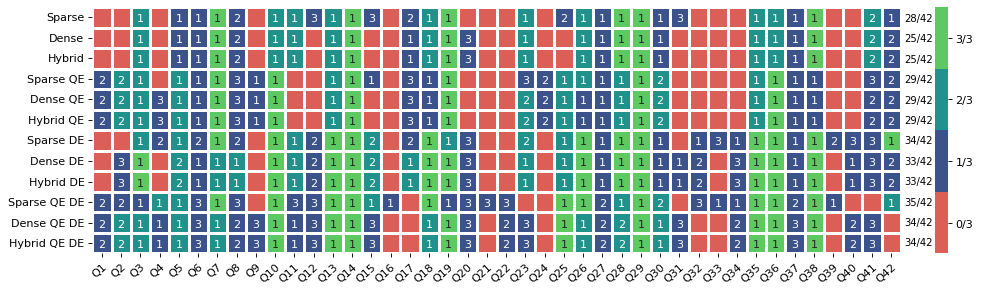

In [15]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=80)

# setting the parameter values for the actual heatmap
# yticklabels = ["Sparse", "Sparse QE", "Sparse DE", "Sparse QE DE",  "Dense", "Dense QE", "Dense DE", "Dense QE DE",
#                "Hybrid", "Hybrid QE", "Hybrid DE", "Hybrid QE DE"]
yticklabels = ["Sparse", "Dense", "Hybrid", 
               "Sparse QE", "Dense QE", "Hybrid QE",  
               "Sparse DE", "Dense DE", "Hybrid DE", 
               "Sparse QE DE",  "Dense QE DE", "Hybrid QE DE"]
xticklabels = ["Q"+str(i+1) for i in range(len(queries))]  

colormap = sn.color_palette('hls',1) + sn.color_palette("viridis",3) 

hm = sn.heatmap(data = np.array(to_be_plotted).transpose(), 
                ax=ax,
                annot=tranposed_ranks,
                fmt='.0f',
                annot_kws={"size": 10, "va": "center_baseline"},
                cbar_kws={"pad":0.035},
                xticklabels=xticklabels,
                yticklabels=yticklabels,
                linewidths = 1,
                linecolor = "white",
                cmap = colormap
               )

hm.collections[0].colorbar.set_ticks([0.125, .375, .625, .875])
hm.collections[0].colorbar.set_ticklabels(['0/3','1/3', '2/3','3/3'])


# Add how often a setting returned a result for a query
total_labels = [[str(len(queries) - tranposed_ranks.isna().sum(axis = 1)[idx])+"/42"] for idx in range(12)]
totals_table = plt.table(cellText=total_labels,
                         colWidths=[0.045],
                         cellLoc = 'center', 
                         rowLoc = 'center',
                         loc='right',
                         edges ='open')
totals_table.scale(1, 1.53)



# displaying the plotted heatmap
plt.xticks(rotation=len(queries), ha='right', rotation_mode='anchor')
[c.set_text('') for c in plt.gca().get_children() if type(c) == plt.Text and c.get_text() == 'nan']
plt.savefig('results_plot.pdf', bbox_inches='tight')
plt.show()
        